<a href="https://colab.research.google.com/github/monsieurshiva/AdvancedDeepLearning/blob/main/ObjectDetection/Object_Detection_RCNN_approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import required libraries
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import imagenet_utils
import imutils
from imutils.object_detection import non_max_suppression
import time
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import sys


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sliding_window import sliding_window
from image_pyramid import image_pyramid 

# New Section

In [ ]:
WIDTH = 600 # resize the images to the size of 600x600
PYR_SCALE = 1.1 # To creating the multiple scaled version of image
WIN_STEP = 16 # Sliding Window step size 
ROI_SIZE = (250,250) # Region of interest (Sub image block) size
INPUT_SIZE = (224, 224) # input image size (We are using mobilenet architecture)
visualize=0 # control parameter for visualizing images
min_conf=0.9 # class probability threshold for the object predicted in each RoI

In [ ]:
# Define the pretrained model - Mobilenet
model = MobileNet(weights="imagenet", include_top=True)

In [ ]:
orig = cv2.imread('/content/dog-cat-under-sheet.jpg')
orig = imutils.resize(orig, width=WIDTH)
(H, W) = orig.shape[:2]

In [ ]:
orig.shape

(400, 600, 3)

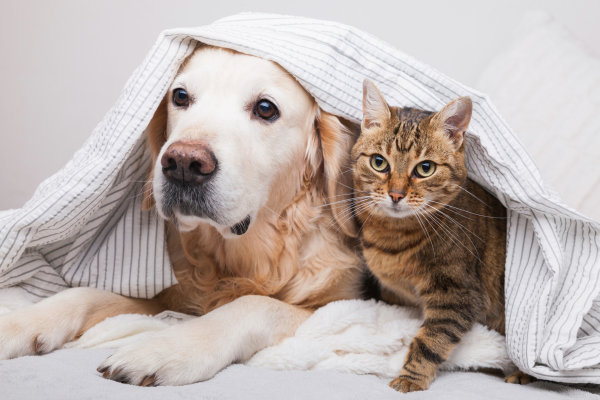

In [ ]:
cv2_imshow(orig)

In [ ]:
pyramid = image_pyramid(orig, scale=PYR_SCALE, minSize=ROI_SIZE)

In [ ]:
rois = []
locs = []

In [ ]:
# for item in pyramid:
#   print(item.shape)

In [ ]:
start = time.time()
# loop over the image pyramid
for image in pyramid:
    # determine the scale factor between the *original* image
    # dimensions and the *current* layer of the pyramid
    scale = W / float(image.shape[1])

    # for each layer of the image pyramid, loop over the sliding
    # window locations
    for (x, y, roiOrig) in sliding_window(image, WIN_STEP, ROI_SIZE):
        # scale the (x, y)-coordinates of the ROI with respect to the
        # *original* image dimensions
        x = int(x * scale)
        y = int(y * scale)
        w = int(ROI_SIZE[0] * scale)
        h = int(ROI_SIZE[1] * scale)

        # take the ROI and pre-process it so we can later classify
        # the region using Keras/TensorFlow
        roi = cv2.resize(roiOrig, INPUT_SIZE)
        roi = img_to_array(roi)
        roi = preprocess_input(roi)

        # update our list of ROIs and associated coordinates
        rois.append(roi)
        locs.append((x, y, x + w, y + h))

        # check to see if we are visualizing each of the sliding
        # windows in the image pyramid
        if visualize > 0:
            # clone the original image and then draw a bounding box
            # surrounding the current region
            clone = orig.copy()
            cv2.rectangle(clone, (x, y), (x + w, y + h),(0, 255, 0), 2)

            # show the visualization and current ROI
            cv2_imshow(clone)
            cv2_imshow(roiOrig)
            
end = time.time()
print("looping over pyramid/windows took {:.5f} seconds".format(end - start))


looping over pyramid/windows took 0.41415 seconds


In [ ]:
rois = np.array(rois, dtype="float32") 

In [ ]:
rois.shape #Total of 294 regions of each size 224x224x3 

(511, 224, 224, 3)

In [ ]:
# Predicting the class of each ROI using the mobilenet model
print("classifying ROIs...")
start = time.time()
preds = model.predict(rois)
end = time.time()
print("classifying ROIs took {:.5f} seconds".format(end - start))

classifying ROIs...
16/16 [==============================] - 28s 2s/step
classifying ROIs took 41.95471 seconds


In [ ]:
preds.shape # Probability of each ROI towards 1000 classes (Mobilenet trained for 1000 classes)

(511, 1000)

In [ ]:
preds = imagenet_utils.decode_predictions(preds, top=1) # top probability prediction

35363/35363 [==============================] - 0s 0us/step


In [ ]:
#create a dictionary with key name as predicted class name (predicted with more than 0.9 confidence)
#keyvalues are its corresponding bounding boxes and probability
labels = {}
for (i, p) in enumerate(preds):
    im_id,obj,prob=p[0]
    if prob>0.85:
        bb=locs[i]
        L=labels.get(obj,[])
        L.append((bb, prob))
        labels[obj] = L

In [ ]:
labels

{'tabby': [((320, 144, 570, 394), 0.8815165)],
 'kuvasz': [((17, 123, 292, 398), 0.8855229)]}

In [ ]:
labels.keys()

dict_keys(['tabby', 'kuvasz'])

showing results for 'tabby'


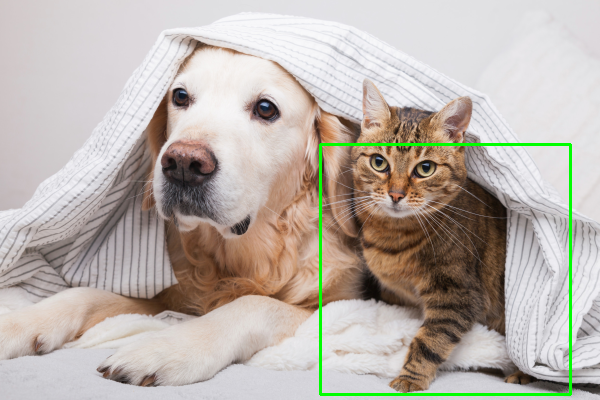

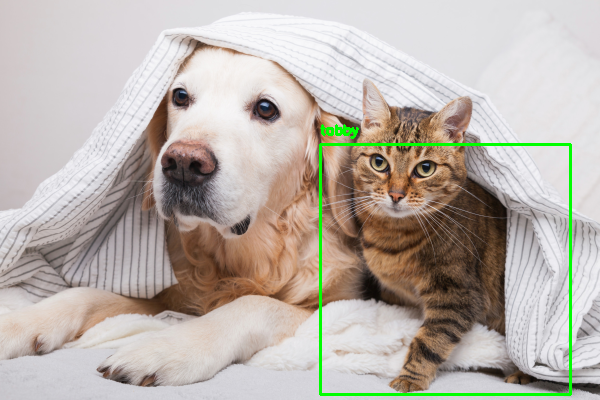

showing results for 'kuvasz'


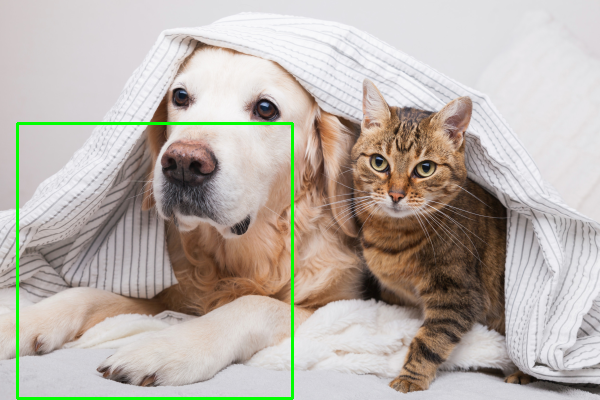

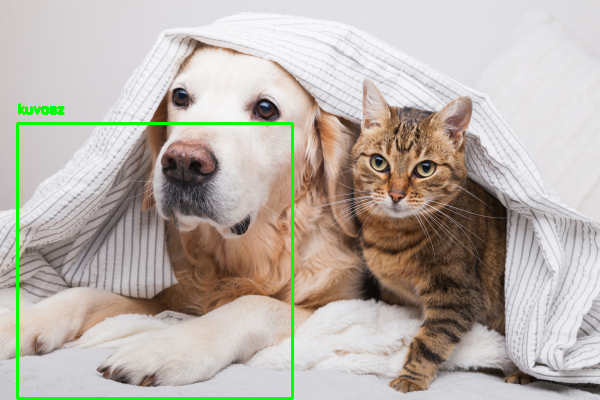

In [ ]:
boxes1=[]
lab=[]
for label in labels.keys():
    # clone the original image so that we can draw on it
    print("showing results for '{}'".format(label))
    clone = orig.copy()

    # loop over all bounding boxes for the current label
    for (box, prob) in labels[label]:
        # draw the bounding box on the image
        (startX, startY, endX, endY) = box
        cv2.rectangle(clone, (startX, startY), (endX, endY),(0, 255, 0), 2)

    # show the results *before* applying non-maxima suppression, then
    # clone the image again so we can display the results *after*
    # applying non-maxima suppression
    cv2_imshow(clone)
    clone = orig.copy()

    # extract the bounding boxes and associated prediction
    # probabilities, then apply non-maxima suppression
    boxes = np.array([p[0] for p in labels[label]])
    proba = np.array([p[1] for p in labels[label]])
    boxes = non_max_suppression(boxes, proba)
    boxes1.append(boxes)
    lab.append(label)
    # loop over all bounding boxes that were kept after applying
    # non-maxima suppression
    for (startX, startY, endX, endY) in boxes:
        # draw the bounding box and label on the image
        cv2.rectangle(clone, (startX, startY), (endX, endY),(0, 255, 0), 2)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        cv2.putText(clone, label, (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)

    # show the output after apply non-maxima suppression
    cv2_imshow(clone)
    

In [ ]:
len(boxes1),lab # After non max supression, at last two objects are present in the image

(2, ['tabby', 'kuvasz'])

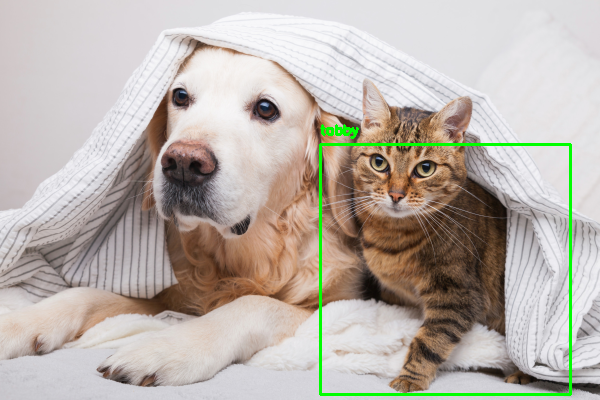

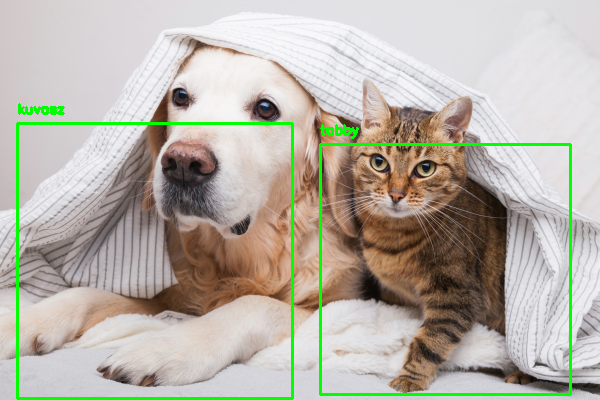

In [ ]:
clone = orig.copy()
for i in range(len(boxes1)):
    bb=boxes1[i][0]
    cv2.rectangle(clone, (bb[0], bb[1]), (bb[2], bb[3]),(0, 255, 0), 2)
    y = bb[1] - 10 if bb[1] - 10 > 10 else bb[1] + 10
    cv2.putText(clone, lab[i], (bb[0], y),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
    cv2_imshow(clone)

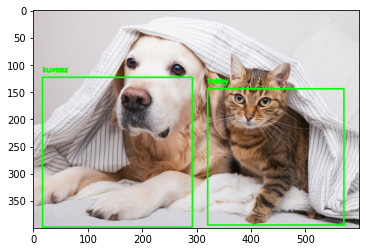

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(cv2.cvtColor(clone, cv2.COLOR_BGR2RGB))
plt.show()